In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf

In [3]:
# Get price data for PHYSX and GLD from yfinance
phys = pd.read_excel('excel_data/PHYS.xlsx')
# Set the index to the date
phys = phys.set_index('Date')
phys = phys.drop(columns=['Close'])
phys.head()

,NAV
Date,
2023-01-20,15.2667
2023-01-19,15.3157
2023-01-18,15.0929
2023-01-17,15.1294
2023-01-16,15.1877


In [65]:
phys = phys.drop(columns=['Date'])
phys.head()

,Close,NAV
0,14.92,15.2667
1,14.96,15.3157
2,14.74,15.0929
3,14.79,15.1294
4,NaN,15.1877


In [61]:
# Convert phys to a dictionary
phys_dict = phys.to_dict()
print(phys_dict)

{'NAV': {Timestamp('2017-12-27 00:00:00'): 10.5389, Timestamp('2017-12-28 00:00:00'): 10.6013, Timestamp('2017-12-29 00:00:00'): 10.6663, Timestamp('2018-01-02 00:00:00'): 10.784, Timestamp('2018-01-03 00:00:00'): 10.7487, Timestamp('2018-01-04 00:00:00'): 10.8267, Timestamp('2018-01-05 00:00:00'): 10.7987, Timestamp('2018-01-08 00:00:00'): 10.8075, Timestamp('2018-01-09 00:00:00'): 10.7445, Timestamp('2018-01-10 00:00:00'): 10.7782, Timestamp('2018-01-11 00:00:00'): 10.8226, Timestamp('2018-01-12 00:00:00'): 10.9499, Timestamp('2018-01-16 00:00:00'): 10.9532, Timestamp('2018-01-17 00:00:00'): 10.8609, Timestamp('2018-01-18 00:00:00'): 10.8605, Timestamp('2018-01-19 00:00:00'): 10.8991, Timestamp('2018-01-22 00:00:00'): 10.9131, Timestamp('2018-01-23 00:00:00'): 10.9748, Timestamp('2018-01-24 00:00:00'): 11.1154, Timestamp('2018-01-25 00:00:00'): 11.0301, Timestamp('2018-01-26 00:00:00'): 11.0438, Timestamp('2018-01-29 00:00:00'): 10.9669, Timestamp('2018-01-30 00:00:00'): 10.9522, Tim

In [59]:
to_df = pd.DataFrame(phys_dict)
to_df.head()

,NAV,Date
0,10.5389,2017-12-27
1,10.6013,2017-12-28
2,10.6663,2017-12-29
3,10.7840,2018-01-02
4,10.7487,2018-01-03


In [78]:
gld = yf.download('GLD', start="2017-12-27", end="2023-01-20")
gld.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-27,122.000000,122.339996,121.879997,122.230003,122.230003,6232700
2017-12-28,122.820000,122.919998,122.559998,122.849998,122.849998,5732700
2017-12-29,123.699997,124.089996,123.459999,123.650002,123.650002,7852100
2018-01-02,124.660004,125.180000,124.389999,125.150002,125.150002,11762500
2018-01-03,125.050003,125.089996,124.099998,124.820000,124.820000,7904300


In [86]:
phys.sort_index(inplace=True)
phys = phys[765:]
phys.head()

,NAV
Date,
2017-12-27,10.5389
2017-12-28,10.6013
2017-12-29,10.6663
2018-01-02,10.7840
2018-01-03,10.7487


In [87]:
print(len(phys))
print(len(gld))

1299
1274


In [39]:
phys = phys.dropna()

Steps:
1) Determine if the spread is mean-reverting
2) If the spread is mean-reverting, determine if GLD has a constant beta to the NAV of PHYS
3) If the beta is constant, calculate the hedge ratio of GLD for PHYS NAV

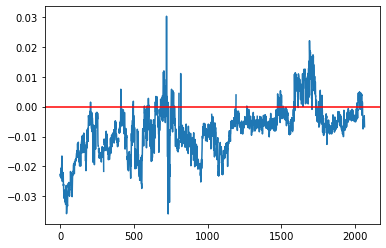

In [69]:
spread = phys['Close'] / phys['NAV'] - 1
# Plot the spread
plt.plot(spread)
plt.axhline(0, color='red')
plt.show()

In [70]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    phys['Close'], phys['NAV']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

MissingDataError: exog contains inf or nans

In [ ]:
# Plot the beta over time
plt.figure(figsize=(12, 8))
plt.plot((phys['NAV'].pct_change().rolling(30).cov(gld['Adj Close'].pct_change()) / (gld['Adj Close'].pct_change().rolling(30).var())), label='Beta')
plt.title('Beta')
plt.legend()
plt.show()

In [88]:
# Determine the hedge ratio
"""
Using statsmodels OLS to find the hedge ratio.
Where the slope of the regression line (line that minimizes the sum of the squared residuals) from OLS is the hedge ratio.
"""
model = OLS(phys['NAV'], gld['Adj Close'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'hedge ratio: {hedge_ratio}')

ValueError: The indices for endog and exog are not aligned

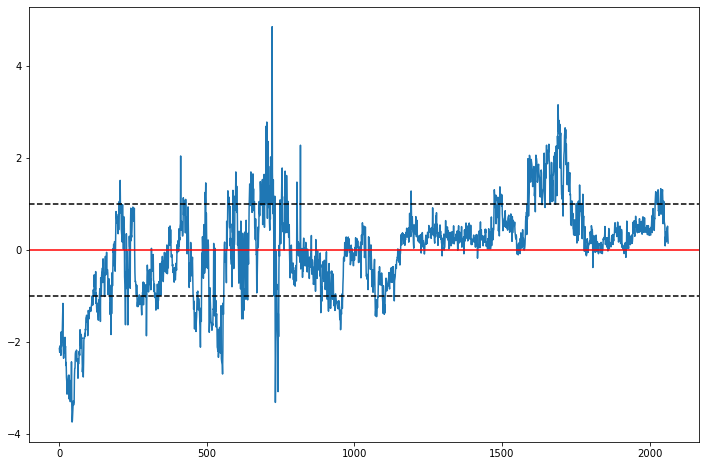

In [33]:
# Spread = (Close/NAV) - 1
spread = phys['Close'] - hedge_ratio * phys['NAV']
# Plot the spread
zscore = (spread - spread.mean()) / np.std(spread)
# Plot the z-score
zscore.plot(figsize=(12,8))
plt.axhline(zscore.mean(), color='red')
plt.axhline(1.0, color='black', linestyle='--')
plt.axhline(-1.0, color='black', linestyle='--')
plt.show()

Determining if the spread is stationary

In [34]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    phys['Close'], phys['NAV']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -4.2296783404878715
p-value: 0.003287510692014663
critical values: [-3.9018592  -3.33915049 -3.04654612]


In [14]:
# Use 2022 - 2023 as the test period
test = phys[phys['Date'] >= '2022-01-01']
test.head()

,Date,Close,NAV
0,2023-01-20,14.92,15.2667
1,2023-01-19,14.96,15.3157
2,2023-01-18,14.74,15.0929
3,2023-01-17,14.79,15.1294
5,2023-01-13,14.86,15.2216
